# 基于卷积神经网络实现猫狗识别

下载数据集到本地，[链接](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data),下载方法可见 README.md

### 数据导入与预处理

In [1]:
import cv2 
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
import shutil
from IPython.display import display
from keras.utils import np_utils
import random
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


# 定义调用模块

### 制作软连接模块

In [7]:
TRAIN_DATA_DIR = '/home/ubuntu/capstone/train'
TEST_DATA_DIR =  '/home/ubuntu/capstone/test'

def make_symlink():

    image_dogs = []
    image_cats = []
    label_dogs = []
    label_cats = []
    test_images = []
    
    if not os.path.exists('newTrain'):
        os.mkdir('newTrain')
        os.mkdir('newTrain/cats')
        os.mkdir('newTrain/dogs')  
    else:
        shutil.rmtree('newTrain')
        os.mkdir('newTrain')
        os.mkdir('newTrain/cats')
        os.mkdir('newTrain/dogs')  
#         for filename in os.listdir('newTrain/cats'):
#             os.remove('newTrain/cats/'+ filename)
#         for filename in os.listdir('newTrain/dogs'):
#             os.remove('newTrain/dogs/'+ filename)
        
    if not os.path.exists('newTest'):
        os.mkdir('newTest')
    else:
        shutil.rmtree('newTest')
        os.mkdir('newTest')
#         if os.path.exists('newTest/test'):
#             for filename in os.listdir('newTest/test'):
#                 os.remove('newTest/test/'+ filename)
#             os.rmdir('newTest/test/')
    
    
    for img in tqdm(os.listdir(TRAIN_DATA_DIR)):
        images = os.path.join(img)
#         display(Image.open(TRAIN_DATA_DIR+'/'+img))
        
        labels = img.split('.')[0]
        if labels == 'cat':
            image_cats.append(images)
            label_cats.append(0)
        else:
            image_dogs.append(images)
            label_dogs.append(1)
    
#     print("images:", image_dogs)
    for img in tqdm(os.listdir(TEST_DATA_DIR)):
        images = os.path.join(img)
        test_images.append(images)
            
    for filename in image_cats:
        os.symlink(TRAIN_DATA_DIR + '/'+filename, 'newTrain/cats/'+filename)
        
    for filename in image_dogs:
        os.symlink(TRAIN_DATA_DIR + '/'+filename, 'newTrain/dogs/'+filename)
    
    os.symlink(TEST_DATA_DIR, 'newTest/test')
    
    return None
    

### 生成器输出模块

In [3]:
def make_generator(image_size, shuff):

#     input_images = []
    
#     for i_img in i_images:
# #       images = cv2.imread(images, cv2.IMREAD_COLOR)
#         images = image.load_img(i_img, target_size=(1,image_size,image_size, 3))
#         images = image.img_to_array(images)
#         input_images.append(images)
#     input_images = np.array(input_images)
    
#     # one hot eencoding
#     input_labels = np_utils.to_categorical(i_labels)
    
    
    # 图像预处理
    datagen = image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True)
    if shuff:
        train_batch = datagen.flow_from_directory('newTrain', target_size=(image_size,image_size),
                                 batch_size=16,shuffle=True,seed=10)
    else:
        train_batch = datagen.flow_from_directory('newTrain', target_size=(image_size,image_size),
                                 batch_size=16,shuffle=False,seed=10)
    
    test_batch = datagen.flow_from_directory('newTest', target_size=(image_size, image_size),
                                 batch_size=16, shuffle=False,class_mode=None, seed=10)
    
    return train_batch, test_batch



### 结果可视化模块

In [216]:
def show_history(t_history,train,valid):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[valid])
    plt.title('Xception Model '+ train +' History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train '+train, 'valid '+valid], loc='upper left')
    plt.show()
    

### 图像可视化模块

In [217]:
def plot_images_labels_prediction(path, images, labels, prediction, num=2):
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    if num > 6 : 
        num=6
    for i in range(0,num):
        idx = np.random.randint(0,len(images))
        img = Image.open(path+images[idx])
        if num > 3:
            ax = plt.subplot(2,3,1+i)
        else:
            ax = plt.subplot(1,3,1+i)
        ax.imshow(img)
        title = ''
        if len(labels) > 0:
            title += "label:" + str(labels[idx])
        if len(prediction) > 0:
            pred = prediction[idx]
            if np.argmax(np.array([1-pred, pred])) == 0:
                title += "This is a cat with prediction: " + str(1-pred)
            else:
                title += "This is a dog with prediction: " + str(pred)
            
        ax.set_title(title, fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

### 图像尺寸输出模块

In [3]:
def find_img_size(pathlist):
    heights, widths = [], []
    for filenames in pathlist:
#         print(filename)
        img = load_img(filenames)
        x = img_to_array(img) # this is a Numpy array with shape (n_c, n_w, n_h)
        heights.append(x.shape[0])
        widths.append(x.shape[1])
        
    x = np.array(widths)
    y = np.array(heights)
    
    plt.scatter(x, y, c='r', alpha=1, marker = 'o')
    plt.title('the size of pictures')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.show()

### 输出小尺寸图像模块

In [4]:
def find_small_img(pathlist):
    small_size = []
    for img_name in pathlist:
        img = load_img(img_name)
        x = img_to_array(img)
        # 检测尺寸小于100*100的图像
        if x.shape[0] < 100 and x.shape[1] < 100:
            small_size.append(img_name.split("/")[-1])
    return small_size

# 数据观察

### 训练集数据及其标签

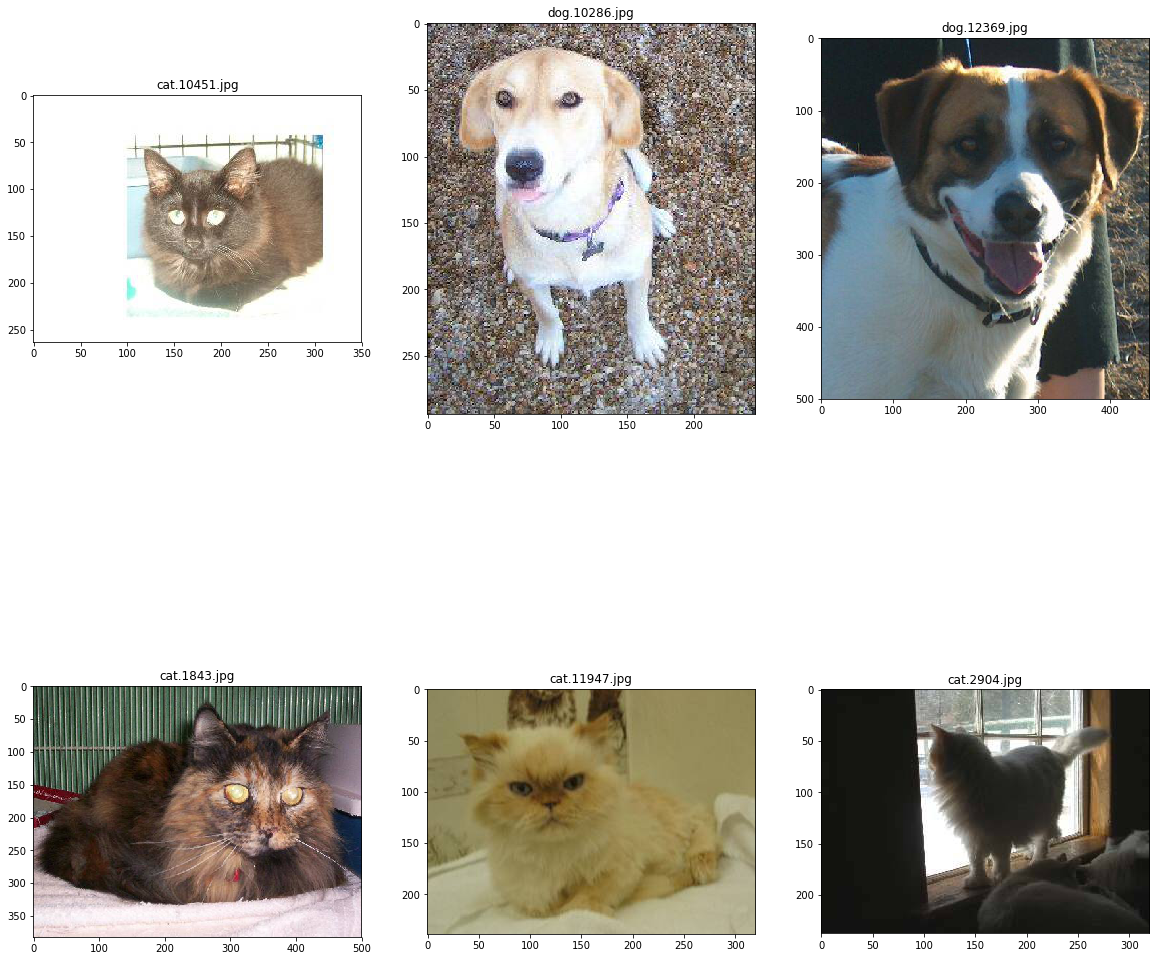

In [9]:
# 随机选取6张训练集数据观察
f_list = os.listdir(TRAIN_DATA_DIR)
fig = plt.gcf()
fig.set_size_inches(20, 20)
for i in range(0,6):
    filename = random.choice(f_list)
    img = cv2.imread(TRAIN_DATA_DIR + "/" + filename)
    # 将图像从BGR转换成RGB图像
    img = img[:,:,::-1]
    ax = plt.subplot(2,3,1+i)
    ax.set_title(filename)
    ax.imshow(img)
plt.show()

### 查看训练集中猫的图像尺寸

100%|██████████| 25000/25000 [00:00<00:00, 557815.50it/s]


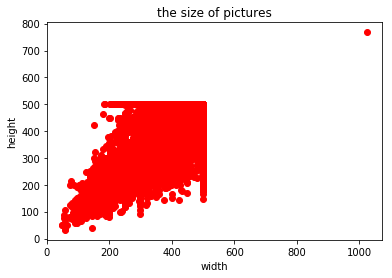

In [8]:
cat_dir = []
dog_dir = []
for img in tqdm(os.listdir(TRAIN_DATA_DIR)):
#     images = os.path.join(TRAIN_DATA_DIR,img)
#     print(img)
    images = TRAIN_DATA_DIR +'/'+ img
#       display(Image.open(TRAIN_DATA_DIR+'/'+img))
        
    labels = img.split('.')[0]
    if labels == 'cat':
        cat_dir.append(images)
    else:
        dog_dir.append(images)

# print(cat_dir)
find_img_size(cat_dir)

### 查看训练集中狗的图像尺寸

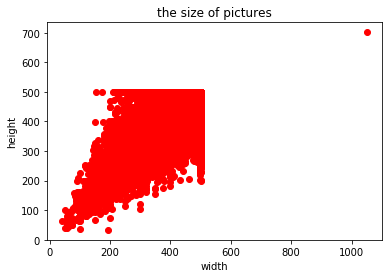

In [9]:
find_img_size(dog_dir)

### 查看小尺寸的猫狗图像

In [61]:
small_cat = find_small_img(cat_dir)
small_dog = find_small_img(dog_dir)
print("small size cats:",small_cat)
print("small size dogs:",small_dog)

small size cats: ['cat.10107.jpg', 'cat.10277.jpg', 'cat.10392.jpg', 'cat.10893.jpg', 'cat.11091.jpg', 'cat.11094.jpg', 'cat.1423.jpg', 'cat.2095.jpg', 'cat.2433.jpg', 'cat.2753.jpg', 'cat.3641.jpg', 'cat.3739.jpg', 'cat.3980.jpg', 'cat.4629.jpg', 'cat.4670.jpg', 'cat.4821.jpg', 'cat.4833.jpg', 'cat.485.jpg', 'cat.4963.jpg', 'cat.5257.jpg', 'cat.5527.jpg', 'cat.5534.jpg', 'cat.5954.jpg', 'cat.596.jpg', 'cat.6402.jpg', 'cat.6614.jpg', 'cat.7314.jpg', 'cat.7487.jpg', 'cat.7703.jpg', 'cat.8087.jpg', 'cat.8138.jpg', 'cat.8470.jpg', 'cat.8504.jpg', 'cat.8585.jpg']
small size dogs: ['dog.10155.jpg', 'dog.10225.jpg', 'dog.10385.jpg', 'dog.10637.jpg', 'dog.10654.jpg', 'dog.10664.jpg', 'dog.10733.jpg', 'dog.10747.jpg', 'dog.11248.jpg', 'dog.11465.jpg', 'dog.11686.jpg', 'dog.1174.jpg', 'dog.12185.jpg', 'dog.1324.jpg', 'dog.1381.jpg', 'dog.2068.jpg', 'dog.2188.jpg', 'dog.2652.jpg', 'dog.296.jpg', 'dog.2965.jpg', 'dog.3074.jpg', 'dog.3147.jpg', 'dog.4134.jpg', 'dog.5618.jpg', 'dog.630.jpg', 'dog.7

### 异常图像的可视化展示

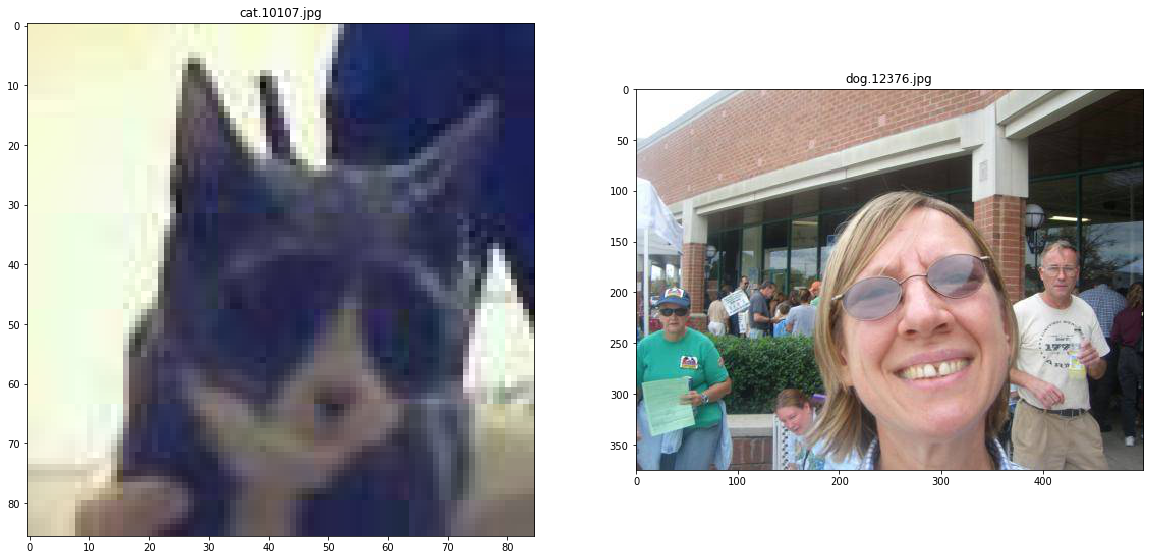

In [3]:
# 展示一张尺寸过小的图像和一张异常图像
fig = plt.gcf()
fig.set_size_inches(20, 20)

img1 = cv2.imread(TRAIN_DATA_DIR + "/" + "cat.10107.jpg")
# 将图像从BGR转换成RGB图像
img1 = img1[:,:,::-1]
ax1 = plt.subplot(1,2,1)
ax1.set_title("cat.10107.jpg")
ax1.imshow(img1)

img2 = cv2.imread(TRAIN_DATA_DIR + "/" + "dog.12376.jpg")
img2 = img2[:,:,::-1]
ax2 = plt.subplot(1,2,2)
ax2.set_title("dog.12376.jpg")
ax2.imshow(img2)

plt.show()

### 将异常数据和较小尺寸图像合并在一起

In [62]:
# 异常的猫和狗数据
bad_cats = ['cat.10536.jpg', 'cat.8470.jpg', 'cat.7377.jpg', 'cat.2520.jpg',
            'cat.8921.jpg',  'cat.9983.jpg', 'cat.7564.jpg', 'cat.4688.jpg',
            'cat.12272.jpg', 'cat.5974.jpg', 'cat.8456.jpg', 'cat.10029.jpg',
            'cat.11184.jpg', 'cat.2939.jpg', 'cat.1139.jpg', 'cat.5418.jpg', 
            'cat.10365.jpg', 'cat.12476.jpg','cat.11039.jpg','cat.10712.jpg',
            'cat.3672.jpg',  'cat.6348.jpg', 'cat.4308.jpg']

bad_dogs = ['dog.12376.jpg', 'dog.2422.jpg', 'dog.5604.jpg', 'dog.7076.jpg', 
            'dog.4367.jpg',  'dog.4218.jpg', 'dog.11299.jpg','dog.4507.jpg', 
            'dog.1773.jpg',  'dog.1194.jpg', 'dog.6475.jpg', 'dog.2614.jpg', 
            'dog.6725.jpg',  'dog.10237.jpg','dog.1625.jpg', 'dog.9517.jpg', 
            'dog.7706.jpg',  'dog.10161.jpg','dog.10801.jpg','dog.8736.jpg',
            'dog.2339.jpg',  'dog.11437.jpg']


small_cat.extend(bad_cats)
small_dog.extend(bad_dogs)

print(small_dog)

['dog.10155.jpg', 'dog.10225.jpg', 'dog.10385.jpg', 'dog.10637.jpg', 'dog.10654.jpg', 'dog.10664.jpg', 'dog.10733.jpg', 'dog.10747.jpg', 'dog.11248.jpg', 'dog.11465.jpg', 'dog.11686.jpg', 'dog.1174.jpg', 'dog.12185.jpg', 'dog.1324.jpg', 'dog.1381.jpg', 'dog.2068.jpg', 'dog.2188.jpg', 'dog.2652.jpg', 'dog.296.jpg', 'dog.2965.jpg', 'dog.3074.jpg', 'dog.3147.jpg', 'dog.4134.jpg', 'dog.5618.jpg', 'dog.630.jpg', 'dog.7011.jpg', 'dog.7369.jpg', 'dog.7374.jpg', 'dog.7421.jpg', 'dog.7459.jpg', 'dog.7765.jpg', 'dog.7772.jpg', 'dog.8428.jpg', 'dog.8450.jpg', 'dog.8570.jpg', 'dog.8987.jpg', 'dog.9246.jpg', 'dog.927.jpg', 'dog.9288.jpg', 'dog.943.jpg', 'dog.9456.jpg', 'dog.9705.jpg', 'dog.12376.jpg', 'dog.2422.jpg', 'dog.5604.jpg', 'dog.7076.jpg', 'dog.4367.jpg', 'dog.4218.jpg', 'dog.11299.jpg', 'dog.4507.jpg', 'dog.1773.jpg', 'dog.1194.jpg', 'dog.6475.jpg', 'dog.2614.jpg', 'dog.6725.jpg', 'dog.10237.jpg', 'dog.1625.jpg', 'dog.9517.jpg', 'dog.7706.jpg', 'dog.10161.jpg', 'dog.10801.jpg', 'dog.8736.

In [63]:
for img in small_cat:
    if small_cat.count(img) > 1:
        small_cat.remove(img)
for img in small_dog:
    if small_dog.count(img) > 1:
        small_dog.remove(img)
print(small_cat)
print(small_dog)

['cat.10107.jpg', 'cat.10277.jpg', 'cat.10392.jpg', 'cat.10893.jpg', 'cat.11091.jpg', 'cat.11094.jpg', 'cat.1423.jpg', 'cat.2095.jpg', 'cat.2433.jpg', 'cat.2753.jpg', 'cat.3641.jpg', 'cat.3739.jpg', 'cat.3980.jpg', 'cat.4629.jpg', 'cat.4670.jpg', 'cat.4821.jpg', 'cat.4833.jpg', 'cat.485.jpg', 'cat.4963.jpg', 'cat.5257.jpg', 'cat.5527.jpg', 'cat.5534.jpg', 'cat.5954.jpg', 'cat.596.jpg', 'cat.6402.jpg', 'cat.6614.jpg', 'cat.7314.jpg', 'cat.7487.jpg', 'cat.7703.jpg', 'cat.8087.jpg', 'cat.8138.jpg', 'cat.8504.jpg', 'cat.8585.jpg', 'cat.10536.jpg', 'cat.8470.jpg', 'cat.7377.jpg', 'cat.2520.jpg', 'cat.8921.jpg', 'cat.9983.jpg', 'cat.7564.jpg', 'cat.4688.jpg', 'cat.12272.jpg', 'cat.5974.jpg', 'cat.8456.jpg', 'cat.10029.jpg', 'cat.11184.jpg', 'cat.2939.jpg', 'cat.1139.jpg', 'cat.5418.jpg', 'cat.10365.jpg', 'cat.12476.jpg', 'cat.11039.jpg', 'cat.10712.jpg', 'cat.3672.jpg', 'cat.6348.jpg', 'cat.4308.jpg']
['dog.10155.jpg', 'dog.10225.jpg', 'dog.10385.jpg', 'dog.10637.jpg', 'dog.10654.jpg', 'dog.

### 移除异常猫狗图像

In [65]:
for img1 in small_cat:
    os.remove(TRAIN_DATA_DIR+'/'+img1)
for img2 in small_dog:
    os.remove(TRAIN_DATA_DIR+'/'+img2)
print("remove successfully!")

remove successfully!


# 建立模型
使用预训练过的模型，使用迁移学习的思想进行模型的建立，并试图进行模型融合训练，使用到的模型有
- Inception v3
- InceptionResNetV2
- Xception

## Xception模型

In [218]:
from keras.applications.xception import Xception, preprocess_input as xception_process
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_process
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet2_process
from keras.models import Model
from keras.optimizers import * # SGD
from IPython.display import SVG
from keras.layers import *
import h5py as h5py

In [194]:
input_tensor = Input(shape=(299,299,3))
input_tensor = Lambda(xception_process)(input_tensor)
model_xception = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

for layer in model_xception.layers:
    layer.trainable = False
    
x = GlobalAveragePooling2D()(model_xception.output)

# model1 = Flatten(name='flatten')(x)
model1 = Dense(1024, activation='relu', name='fc1')(x)
# model1 = Dense(1024, activation='relu', name='fc2')(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(2, activation='softmax', name='prediction')(model1)

model_xception_pred = Model(model_xception.input, model1, name='xception')


- 选择损失函数(loss)为：categorical_crossentropy  
- 选择优化器(optimizer)为：Nadam() 
- 选择评价函数为：accuracy

In [195]:
model_xception_pred.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0002, momentum=0.9), metrics=['accuracy'])

### 训练模型

In [196]:
epochs = 10
image_size = 299
batch_size = 16

make_symlink()
train_generator1, test_generator1 = make_generator(image_size, shuff=True)
train_generator, test_generator = make_generator(image_size, shuff=False)
# xception_history = model_xception_pred.fit_generator(train_generator, epochs=epochs, verbose=1)

100%|██████████| 12500/12500 [00:00<00:00, 586451.90it/s]


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [199]:
from keras.callbacks import ModelCheckpoint
if not os.path.exists('checkpoints_1'):
    os.mkdir('checkpoints_1')
checkpoint1 = ModelCheckpoint('checkpoints_1/weights.{epoch:02d}-{loss:.4f}.hdf5', monitor='loss', 
                             verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

CALL = [checkpoint1]

In [200]:
xception_history = model_xception_pred.fit_generator(train_generator1, epochs=epochs, 
                                                     steps_per_epoch=len(train_generator1)/batch_size,verbose=1,callbacks=CALL)

Epoch 1/10
98/97 [==============================] - 30s 309ms/step - loss: 0.4061 - acc: 0.9126
Epoch 2/10
98/97 [==============================] - 30s 308ms/step - loss: 0.3220 - acc: 0.9228
Epoch 3/10
98/97 [==============================] - 30s 307ms/step - loss: 0.2409 - acc: 0.9617
Epoch 4/10
98/97 [==============================] - 30s 308ms/step - loss: 0.2128 - acc: 0.9592
Epoch 5/10
98/97 [==============================] - 30s 308ms/step - loss: 0.1939 - acc: 0.9592
Epoch 6/10
98/97 [==============================] - 30s 308ms/step - loss: 0.1681 - acc: 0.9585
Epoch 7/10
98/97 [==============================] - 30s 308ms/step - loss: 0.1485 - acc: 0.9688
Epoch 8/10
98/97 [==============================] - 30s 308ms/step - loss: 0.1530 - acc: 0.9636
Epoch 9/10
98/97 [==============================] - 30s 308ms/step - loss: 0.1456 - acc: 0.9585
Epoch 10/10
98/97 [==============================] - 30s 308ms/step - loss: 0.1344 - acc: 0.9643


### 模型可视化

In [207]:
# SVG(model_to_dot(model_xception_pred, show_shapes=True).create(prog="dot", format='svg'))

### 执行结果可视化

In [208]:
# # accuracy 可视化
# show_history(xception_history, 'acc'， None)

In [210]:
# loss 可视化
# show_history(xception_history, 'loss')

## 建立混合模型

### Xception 模型

In [219]:
from keras.applications import xception
tensor = Input(shape=(299,299,3))
x_tensor = Lambda(xception_process)(tensor)
model_xception = Xception(input_tensor=x_tensor, include_top=False, weights='imagenet') #input_shape=(299,299,3)
x = GlobalAveragePooling2D()(model_xception.output)
# xception_model = Dense(128, activation='relu')(x)
xception_model = Model(model_xception.input, x)

xception_train = xception_model.predict_generator(train_generator, verbose=1)
xception_test = xception_model.predict_generator(test_generator, verbose=1)

# 将特征向量写入数据文件
with h5py.File("gap_Xception.h5") as h:
    h.create_dataset("train", data=xception_train)
    h.create_dataset("test", data=xception_test)
    h.create_dataset("t_label", data=train_generator.classes)


782/782 [==============================] - 294s 375ms/step


### Inception v3 模型

In [220]:
from keras.applications import inception_v3
y_tensor = Lambda(inception_v3_process)(tensor)
model_inception_v3 = InceptionV3(input_tensor=y_tensor, include_top=False, weights='imagenet') # input_shape=(299,299,3)
y = GlobalAveragePooling2D()(model_inception_v3.output)
# inceptionV3_model = Dense(128, activation='relu')(y)
inceptionV3_model = Model(inputs=tensor, outputs=y)

inceptionV3_train = inceptionV3_model.predict_generator(train_generator, verbose=1)
inceptionV3_test = inceptionV3_model.predict_generator(test_generator, verbose=1)

# 将特征向量写入数据文件
with h5py.File("gap_InceptionV3.h5") as h:
    h.create_dataset("train", data=inceptionV3_train)
    h.create_dataset("test", data=inceptionV3_test)
    h.create_dataset("t_label", data=train_generator.classes)

782/782 [==============================] - 172s 219ms/step


### InceptionResNetV2 模型

In [221]:
from keras.applications import inception_resnet_v2
z_tensor = Lambda(inception_resnet2_process)(tensor)
model_inceptionresnetv2 = InceptionResNetV2(input_tensor=z_tensor, include_top=False, weights='imagenet') # input_shape=(299,299,3)
z = GlobalAveragePooling2D()(model_inceptionresnetv2.output)
# inceptionresnetv2_model = Dense(128, activation='relu')(z)
inceptionresnetv2_model = Model(model_inceptionresnetv2.input, z)

inceptionresnetv2_train = inceptionresnetv2_model.predict_generator(train_generator, verbose=1)
inceptionresnetv2_test = inceptionresnetv2_model.predict_generator(test_generator, verbose=1)

# 将特征向量写入数据文件
with h5py.File("gap_InceptionResNetV2.h5") as h:
    h.create_dataset("train", data=inceptionresnetv2_train)
    h.create_dataset("test", data=inceptionresnetv2_test)
    h.create_dataset("t_label", data=train_generator.classes)

782/782 [==============================] - 373s 477ms/step


### 从文件中读取特征向量

In [222]:
from sklearn.utils import shuffle
from keras.utils import to_categorical

train_images = []
train_labels = []
valid_images = []
valid_labels = []
test_data = []

h5File = ["gap_Xception.h5", "gap_InceptionResNetV2.h5", "gap_InceptionV3.h5"] #, "gap_InceptionV3.h5", "gap_InceptionResNetV2.h5"
for filename in h5File:
    print(filename)
    with h5py.File(filename, 'r') as h:
        train_images.append(np.array(h['train']))
        train_labels = np.array(h['t_label'])
        test_data.append(np.array(h['test']))


# 将list竖直拼接
train_images = np.concatenate(train_images, axis=1)
# train_labels = to_categorical(train_labels)
print('train_labels1:',len(train_images[0]))

print('train_labels2:',train_labels[0:12501])
# train_labels = np.concatenate(train_labels, axis=1)
test_data = np.concatenate(test_data, axis=1)

train_images, train_labels = shuffle(train_images, train_labels)
print("train_labels3:", train_labels.shape)

gap_Xception.h5
gap_InceptionResNetV2.h5
gap_InceptionV3.h5
train_labels1: 5632
train_labels2: [0 0 0 ... 0 0 1]
train_labels3: (25000,)


In [223]:
train_input = Input(train_images.shape[1:])
model = Dense(1024, activation='relu')(train_input)
model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)

new_model = Model(train_input, model)

In [224]:
new_model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.0002, decay=0.00002, momentum=0.9), metrics=['accuracy'])  #SGD(lr=0.0002, momentum=0.9)

In [225]:
from keras.callbacks import ModelCheckpoint, TensorBoard
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
checkpoint = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', 
                             verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, 
            write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

CALLBACKS = [checkpoint, tensorboard]

In [226]:
new_model_history = new_model.fit(train_images, train_labels, batch_size=32, epochs=10, verbose=1, 
                                  validation_split=0.2, callbacks=CALLBACKS)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 9s 433us/step - loss: 0.1312 - acc: 0.9715 - val_loss: 0.0481 - val_acc: 0.9920
Epoch 2/10
20000/20000 [==============================] - 7s 354us/step - loss: 0.0419 - acc: 0.9918 - val_loss: 0.0329 - val_acc: 0.9932
Epoch 3/10
20000/20000 [==============================] - 7s 357us/step - loss: 0.0312 - acc: 0.9930 - val_loss: 0.0275 - val_acc: 0.9930
Epoch 4/10
20000/20000 [==============================] - 7s 365us/step - loss: 0.0265 - acc: 0.9938 - val_loss: 0.0238 - val_acc: 0.9942
Epoch 5/10
20000/20000 [==============================] - 7s 356us/step - loss: 0.0252 - acc: 0.9932 - val_loss: 0.0221 - val_acc: 0.9938
Epoch 6/10
20000/20000 [==============================] - 7s 353us/step - loss: 0.0227 - acc: 0.9942 - val_loss: 0.0205 - val_acc: 0.9944
Epoch 7/10
20000/20000 [==============================] - 7s 346us/step - loss: 0.0206 - acc: 0.9948 - val_loss: 0.0194 - v

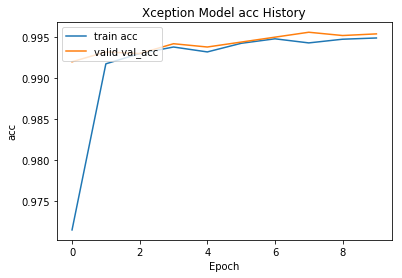

In [227]:
# accuracy 可视化
show_history(new_model_history, 'acc', 'val_acc')

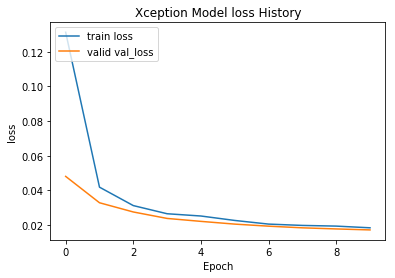

In [228]:
# loss 可视化
show_history(new_model_history, 'loss', 'val_loss')

## 测试

In [229]:
test_pred = new_model.predict(test_data, verbose=1)

12500/12500 [==============================] - 10s 782us/step


### 检查点加载

In [230]:
check_path = 'checkpoints/'
path_list = os.listdir(check_path)
checkpoint = []
for fname in path_list:
    file = fname.split('-')[1]
    file = file.split('.hdf5')[0]
    checkpoint.append(file)
minloss = checkpoint.index(min(checkpoint))
best_loss = path_list[minloss]

new_model.load_weights(check_path + best_loss)
test_pred_check = new_model.predict(test_data, verbose=1)

12500/12500 [==============================] - 2s 123us/step


### 测试数据可视化

Found 12500 images belonging to 1 classes.


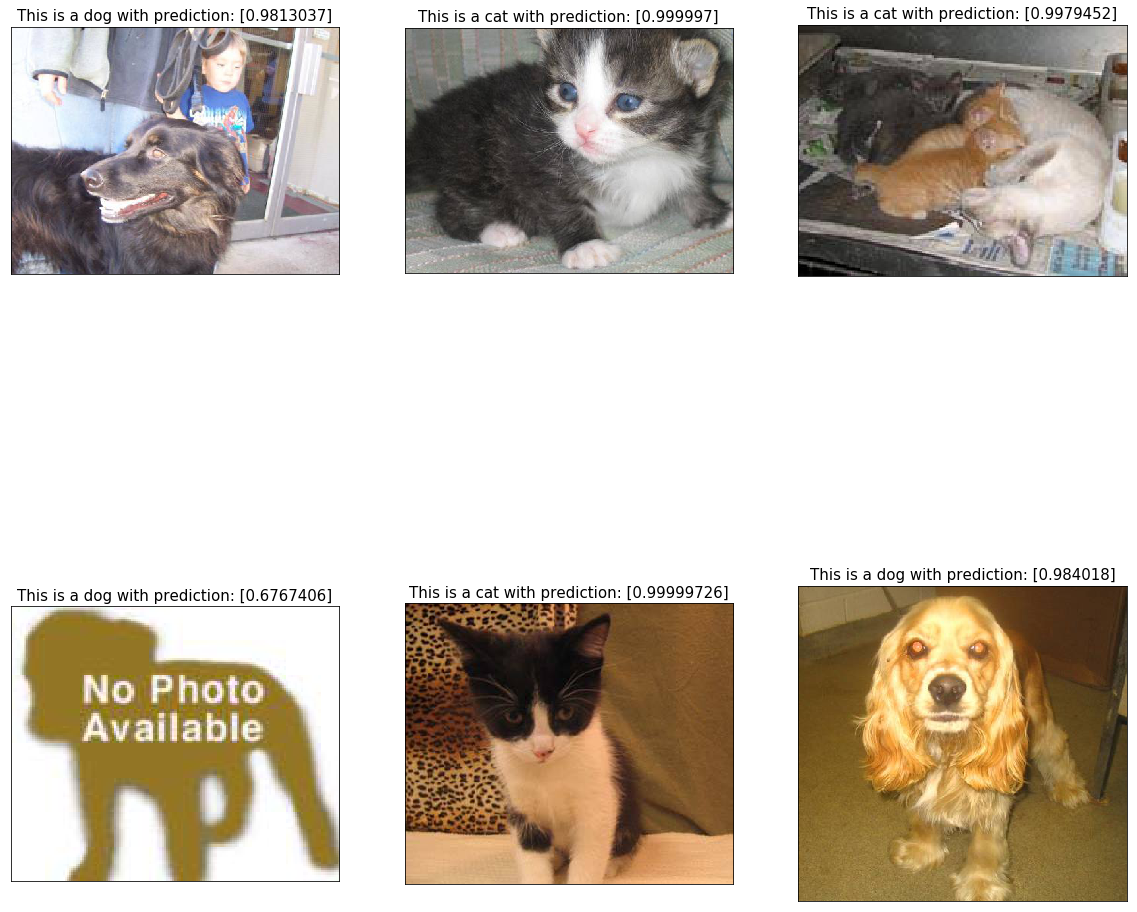

In [231]:
gendata = image.ImageDataGenerator()
test_generator = gendata.flow_from_directory("newTest", (299, 299), shuffle=False, 
                                         batch_size=16, class_mode=None)

plot_images_labels_prediction('newTest/', test_generator.filenames, [], test_pred, num=6)

In [232]:
import pandas as pd
test_pred = test_pred.clip(min=0.005, max=0.995)

file = pd.read_csv("sample_submission.csv")

for i, filename in enumerate(test_generator.filenames):
    index = filename.split('/')[1]
    index = int(index.split('.')[0])
    file.set_value(index-1, 'label', test_pred[i])

# for i, filename in enumerate(os.listdir('newTest/test')):
#     index = int(filename.split('.')[0])
#     file.set_value(index-1, 'label', test_pred[i])
    
file.to_csv('submission.csv', index=None)
file.head(10)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
